Old modules cleared from cache.
Generated 5050 transactions.


,timestamp,user_id,amount,merchant_id,location,is_fraud
0,2023-01-01 00:52:54,154,12.712186,M13,B,0
1,2023-01-01 01:58:27,365,27.044313,M5,D,0
2,2023-01-01 02:14:20,404,12.949671,M15,D,0
3,2023-01-01 03:21:34,116,26.007141,M8,A,0
4,2023-01-01 04:18:50,343,22.220789,M7,B,0


Training set shape: (4250, 26)
Validation set shape: (750, 26)
Test set shape: (5050, 26)
Training Autoencoder with 26 features for 20 epochs...
Epoch 1/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.2031 - val_loss: 0.1122
Epoch 2/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1467 - val_loss: 0.0659
Epoch 3/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1002 - val_loss: 0.0509
Epoch 4/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0743 - val_loss: 0.0466
Epoch 5/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0568 - val_loss: 0.0413
Epoch 6/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0432 - val_loss: 0.0354
Epoch 7/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0355 - val_loss: 0.0322
Epoch 8/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0330 - val_loss: 0.0306
Epoch 9/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0308 - val_loss: 0.0296
Epoch 10/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0298 - val_loss: 0.0278
Epoch 11/20
34

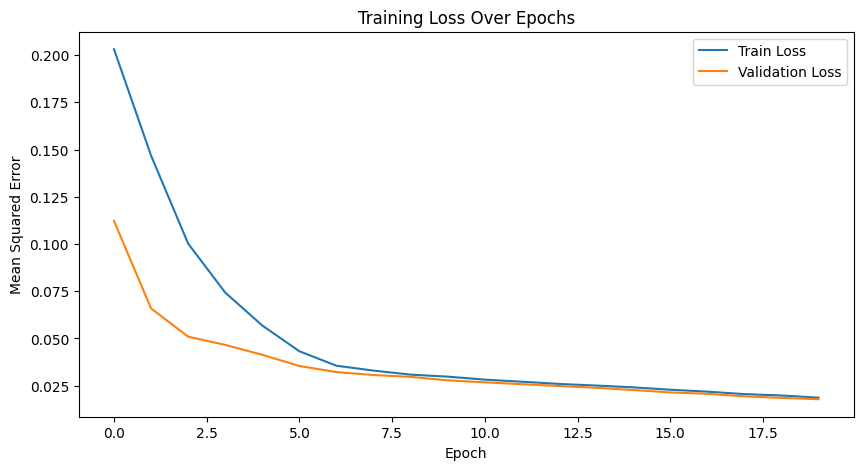

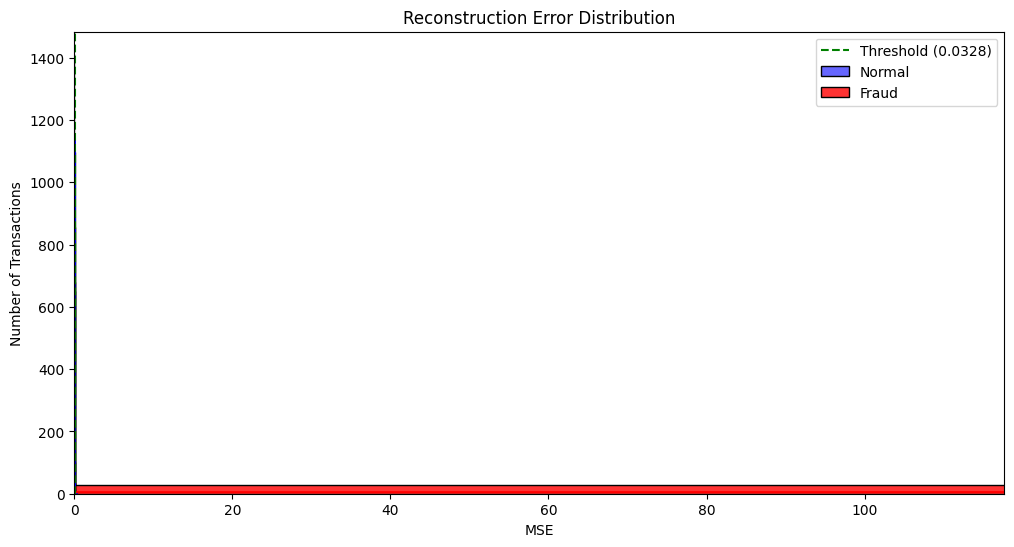

In [6]:
# training.py or notebook cell

# %% 1. Imports
import sys
modules_to_delete = [m for m in sys.modules if m.startswith('model_train') or m.startswith('data_prep')]
for m in modules_to_delete:
    del sys.modules[m]

print("Old modules cleared from cache.")
import os
import importlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# Make sure src folder is in path
sys.path.append('../src')
import data_prep
import model_train
importlib.reload(data_prep)
importlib.reload(model_train)

from data_prep import generate_synthetic_data, preprocess_data
from model_train import train_and_evaluate, calculate_reconstruction_error

# %% 2. Make sure the models folder exists
os.makedirs('../models', exist_ok=True)

# %% 3. Generate synthetic transaction data
df = generate_synthetic_data(n_normal=5000, n_fraud=50)
print(f"Generated {len(df)} transactions.")
display(df.head())

# %% 4. Preprocess data
X_train, X_val, X_test, y_test, artifacts = preprocess_data(df)
print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Test set shape: {X_test.shape}")

# %% 5. Train the autoencoder
history, model = train_and_evaluate(
    X_train, X_val, X_test, y_test, artifacts, epochs=20
)

# %% 6. Plot training loss
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Mean Squared Error")
plt.legend()
plt.show()

# %% 7. Plot reconstruction error histogram
with open('../models/artifacts.pkl', 'rb') as f:
    artifacts = pickle.load(f)

THRESHOLD = artifacts['threshold']
mse_test = calculate_reconstruction_error(model, X_test)

plt.figure(figsize=(12,6))
sns.histplot(mse_test[y_test==0], bins=50, kde=True, label='Normal', color='blue', alpha=0.6)
sns.histplot(mse_test[y_test==1], bins=50, kde=True, label='Fraud', color='red', alpha=0.8)
plt.axvline(THRESHOLD, color='green', linestyle='--', label=f'Threshold ({THRESHOLD:.4f})')
plt.title("Reconstruction Error Distribution")
plt.xlabel("MSE")
plt.ylabel("Number of Transactions")
plt.legend()
plt.xlim(0, np.percentile(mse_test, 99.5))
plt.show()
